In [1]:
import pandas as pd
import altair as alt
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import shapely.wkt
import pandas_profiling

In [2]:
with open('b_json_count.json') as data_file:
    b_json_count = json.load(data_file)
squirrel_b_json = alt.Data(values = b_json_count['features'])

In [3]:
with open('alt_json_count.json') as data_file:
    alt_json_count = json.load(data_file)
alt_base_layer_data_count = alt.Data(values = alt_json_count['features'])

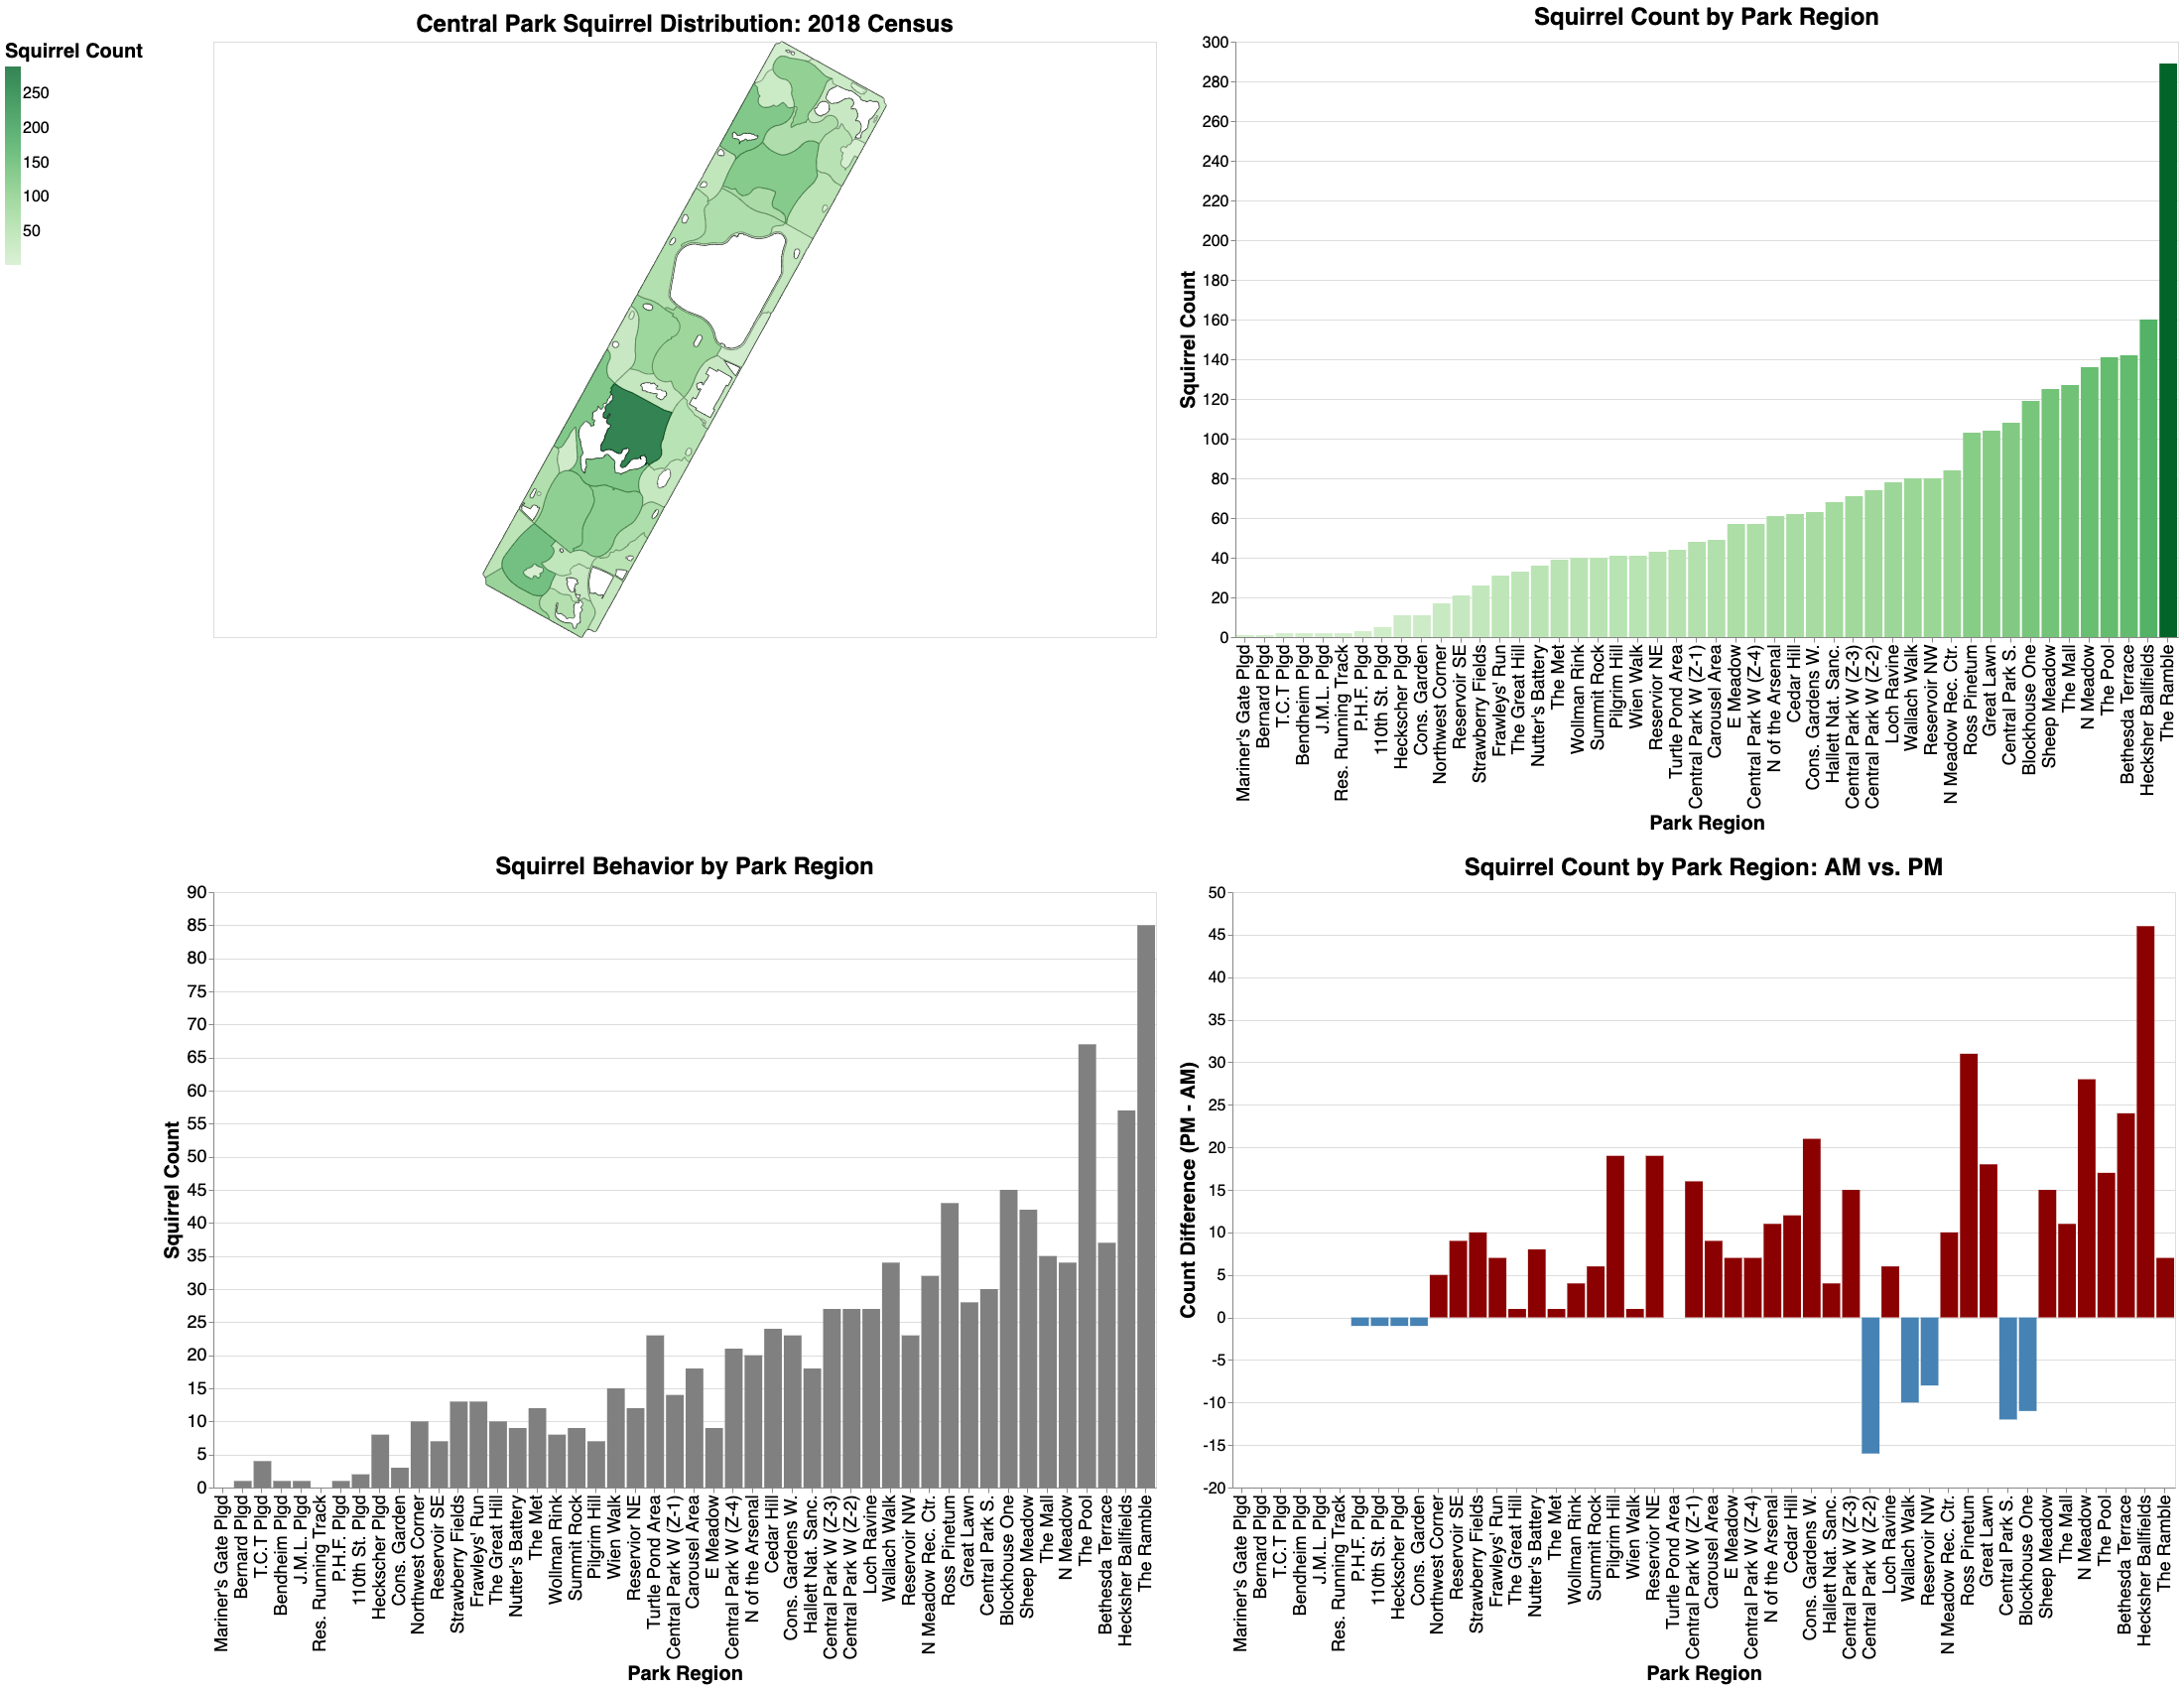

In [4]:
##################################
# PLOT MAP of SQUIRREL COUNT
##################################

def plot_map_total_count(selection):
    # Plot of squirrel count
    base_map = alt.Chart(alt_base_layer_data_count).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=950,
        height=600
    )

    # Add Choropleth Layer
    choropleth = (alt.Chart(alt_base_layer_data_count, 
                            title = "Central Park Squirrel Distribution: 2018 Census")
    .mark_geoshape()
    .add_selection(selection)
    .encode(
    # SELECTION SINGLE CONDITIONS -- Color is grey if not selected
        color = alt.condition(selection, 
                              'properties.Unique_Squirrel_ID:Q', 
                              alt.value('grey'),
            title = 'Squirrel Count',
            scale=alt.Scale(scheme='greens'),
            legend = alt.Legend(labelFontSize = 16, 
                                titleFontSize = 20, 
                                tickCount = 5,
                               orient = "left")),
        opacity=alt.condition(selection, 
                              alt.value(0.8), 
                              alt.value(0.1)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")]
    ))
    
    return(base_map + choropleth)

# Sort data by squirrel count to display sites in ascending order
sort_order = ["Mariner's Gate Plgd", 'Bernard Plgd', 'T.C.T Plgd', 'Bendheim Plgd', 'J.M.L. Plgd', 
    'Res. Running Track', 'P.H.F. Plgd', '110th St. Plgd', 'Heckscher Plgd', 'Cons. Garden', 
    'Northwest Corner', 'Reservoir SE', 'Strawberry Fields', "Frawleys' Run", 'The Great Hill', 
    "Nutter's Battery", 'The Met', 'Wollman Rink', 'Summit Rock', 'Pilgrim Hill', 'Wien Walk', 
    'Reservior NE', 'Turtle Pond Area', 'Central Park W (Z-1)', 'Carousel Area', 'E Meadow', 
    'Central Park W (Z-4)', 'N of the Arsenal', 'Cedar Hill', 'Cons. Gardens W.', 'Hallett Nat. Sanc.', 
    'Central Park W (Z-3)', 'Central Park W (Z-2)', 'Loch Ravine', 'Wallach Walk', 'Reservoir NW', 
    'N Meadow Rec. Ctr.', 'Ross Pinetum', 'Great Lawn', 'Central Park S.', 'Blockhouse One', 'Sheep Meadow', 
    'The Mall', 'N Meadow', 'The Pool', 'Bethesda Terrace', 'Hecksher Ballfields', 'The Ramble']

##########################################
# PLOT TOTAL SQUIRREL COUNT
##########################################
def plot_bar_total_count(selection):
    count_bar = (alt.Chart(alt_base_layer_data_count, 
                           title = 'Squirrel Count by Park Region')
    .mark_bar()
    .add_selection(selection)
    .encode(
        x = alt.X('properties.sitename_short:N', 
                  title = "Park Region", 
                  axis = alt.Axis(labelFontSize = 18,
                                  titleFontSize = 20), 
                  sort = sort_order),
        y = alt.Y('properties.Unique_Squirrel_ID:Q', 
                  title = "Squirrel Count", 
                  axis = alt.Axis(labelFontSize = 16, 
                                  titleFontSize = 20)),
        color = alt.Color('properties.Unique_Squirrel_ID:Q',
                         scale=alt.Scale(scheme='greens')),

    # SELECTION SINGLE CONDITIONS -- opacity is 0.2 if not selected
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")])
    .properties(width = 950, height = 600))   
    return(count_bar)

################################################
# PLOT DIFFERENCE in COUNT by TIME OF DAY
################################################
def plot_bar_count_diff(selection):
    area_count_shift = (alt.Chart(alt_base_layer_data_count)
    .mark_bar()
    .add_selection(selection)
    .encode(
        alt.X('properties.sitename_short:N',
              axis = alt.Axis(labelFontSize = 18,
                                           titleFontSize = 20), 
              title = "Park Region",
              sort = sort_order),
        alt.Y('properties.Count_difference:Q', 
              title = "Count Difference (PM - AM)", 
              axis = alt.Axis(labelFontSize = 16, 
                              titleFontSize = 20)),
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        color=alt.condition(
            # If count is negative, color bar blue. If positive, red.
            alt.datum['properties.Count_difference'] > 0,
            alt.value("darkred"),  # The positive color
            alt.value("steelblue")  # The negative color
        ),
        tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                   alt.Tooltip('properties.Count_difference:Q', title="Count difference")]
    ).properties(title = "Squirrel Count by Park Region: AM vs. PM",
                 width = 950,
                height = 600))
    return(area_count_shift)


###################################
# PLOT BEHAVIOR by PARK AREA
###################################
def plot_bar_behavior(selection):
    #b = ['Running or Chasing', 'Climbing', 'Eating or Foraging', 'Vocalizing', 'Approaches Humans']
    #b_dropdown = alt.binding_select(options=b)
    #b_select = alt.selection_single(fields=['properties.behavior'], 
    #                                bind = b_dropdown, name="Squirrel", 
    #                                init = {'properties.behavior' : 'Running or Chasing'})

    b_chart = (alt.Chart(squirrel_b_json)
        .mark_bar(color = 'gray')
        #.add_selection(b_select)
        .add_selection(selection)
        .encode(alt.X('properties.sitename_short:N', title = "Park Region", sort = sort_order, axis = alt.Axis(labelFontSize = 18,
                                                   titleFontSize = 20)), 
                alt.Y('properties.Running_or_Chasing:Q', title = 'Squirrel Count', axis = alt.Axis(labelFontSize = 18,
                                                   titleFontSize = 20)),
                opacity = alt.condition(brush, 
                                    alt.value(1.0), 
                                    alt.value(0.2)),
                tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                           alt.Tooltip('properties.b_count:Q', title="Squirrel Count")]
               )
        #.transform_filter(b_select)
        .properties(title = "Squirrel Behavior by Park Region",
                     width = 950,
                    height = 600))
    return b_chart


# Create selection conditions and link plots by setting resolve = 'global'
brush = alt.selection_multi(fields = ['properties.sitename_short'],
    resolve='global'
)


# Render stacked plots
((plot_map_total_count(brush) | plot_bar_total_count(brush)) & (plot_bar_behavior(brush) | plot_bar_count_diff(brush))).configure_title(fontSize = 24)

# source (code): https://www.districtdatalabs.com/altair-choropleth-viz